In [48]:
import os


if 'original_dir' not in globals():
    original_dir = os.getcwd()
os.chdir(os.path.join(original_dir, os.pardir))
# parent_dir = os.path.abspath(os.path.join(original_dir, os.pardir))
# os.listdir()
# os.chdir(parent_dir)


In [49]:
os.getcwd()

'c:\\Users\\G\\Desktop\\UZH_Network'

In [50]:
os.listdir("data/csv/HS24/")

['.keep',
 'VVZ_HS24_modules.csv',
 'VVZ_HS24_study_programs.csv',
 'VVZ_HS24_time_schedule.csv']

In [55]:
df = pd.read_csv("data/csv/HS24/VVZ_HS24_time_schedule.csv")
df.head()

,Event Name,Event Code,Instructor,Course Languages,Component of Module
0,NaN,NaN,NaN,NaN,NaN
1,Forschungsseminar Protein Engineering,BCH802,Andreas Plückthun,English,NaN
2,Research Seminar Protein Dynamics (Progress Re...,BCH805,Benjamin Schuler,English,NaN
3,Research seminars,BCH405,Amedeo Caflisch,English,BCH 405 Research seminars
4,Blockcourse: Social science Research projects,44LM001,Dorothea Lüddeckens,German,Social science Research projects


In [25]:
import pandas as pd
import os




df = pd.read_csv("data/csv/HS24/VVZ_HS24_study_programs.csv", encoding="utf-16")
df = pd.read_csv("data/csv/HS24/VVZ_HS24_time_schedule.csv", encoding="utf-16")
df.head()

,Program,Languages,Regulations,Organization,Responsible Instructor,Coordination,Part Of
0,Doctoral Program Drug Discovery,English,https://www.mnf.uzh.ch/en/studium/reglemente.html,Faculty of Science,Michael Arand,Olga von Niederhäusern,Joint Doctorate at the Faculty of Science of t...
1,Doctoral Program Evolutionary Biology,English,https://www.mnf.uzh.ch/en/studium/reglemente.html,Faculty of Science,Kentaro Shimizu,Anton Weingrill,Joint Doctorate at the Faculty of Science of t...
2,Doctoral Program Mathematics,English,NaN,Faculty of Science,Benjamin Schlein,Jessica Bolsinger,Doctorate Faculty of Science
3,Major 90 Artificial Intelligence (Fast Track),English,https://www.oec.uzh.ch/en/studies/general/regu...,NaN,NaN,NaN,Master of Science UZH in Informatics (PVO08)
4,Concentration General Geography,English,NaN,Faculty of Science,NaN,NaN,Master of Science Faculty of Science (120) (2021)


In [52]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def create_graph(df):

    G = nx.Graph()
    for org in df["Organization"].dropna().unique():
        programs = df[df["Organization"] == org]["Program"].tolist()
        for i in range(len(programs)):
            for j in range(i + 1, len(programs)):
                G.add_edge(programs[i], programs[j])
    return G

def plot_graph(G):

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(
        G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2, font_size=8
    )
    plt.title("Program Collaboration Graph Based on Organization", fontsize=16)
    plt.show()

def compute_metrics_and_plot(G):

    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    degree_dist = [d for n, d in G.degree()]
    clustering_coefficient = nx.average_clustering(G)
    connected_components = list(nx.connected_components(G))
    largest_component_size = len(max(connected_components, key=len))
    
    metrics = {
        "Number of Nodes": num_nodes,
        "Number of Edges": num_edges,
        "Average Degree": sum(degree_dist) / num_nodes if num_nodes > 0 else 0,
        "Clustering Coefficient": clustering_coefficient,
        "Number of Connected Components": len(connected_components),
        "Largest Component Size": largest_component_size,
    }
    
    print("Graph Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value}")
    
    # Plot degree distribution
    plt.figure(figsize=(10, 6))
    plt.hist(degree_dist, bins=range(min(degree_dist), max(degree_dist) + 2), color="skyblue", edgecolor="black")
    plt.title("Degree Distribution", fontsize=16)
    plt.xlabel("Degree", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


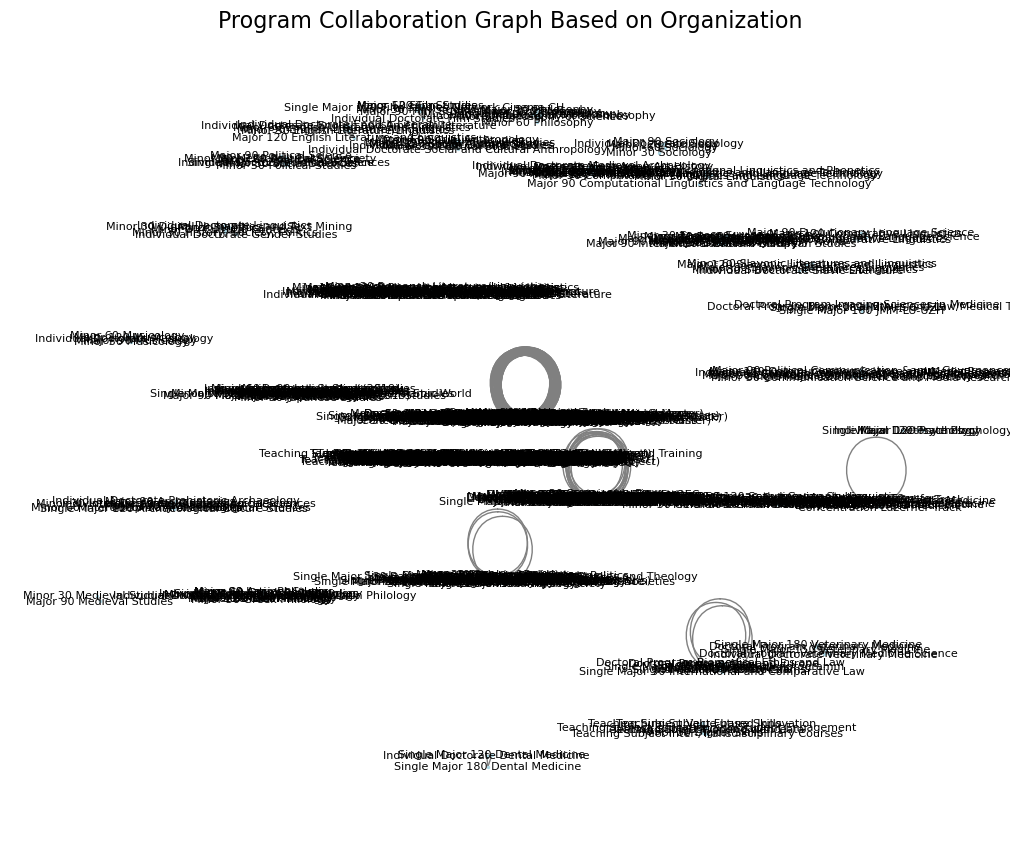

Graph Metrics:
Number of Nodes: 550
Number of Edges: 16278
Average Degree: 59.192727272727275
Clustering Coefficient: 0.9963636363636363
Number of Connected Components: 31
Largest Component Size: 135


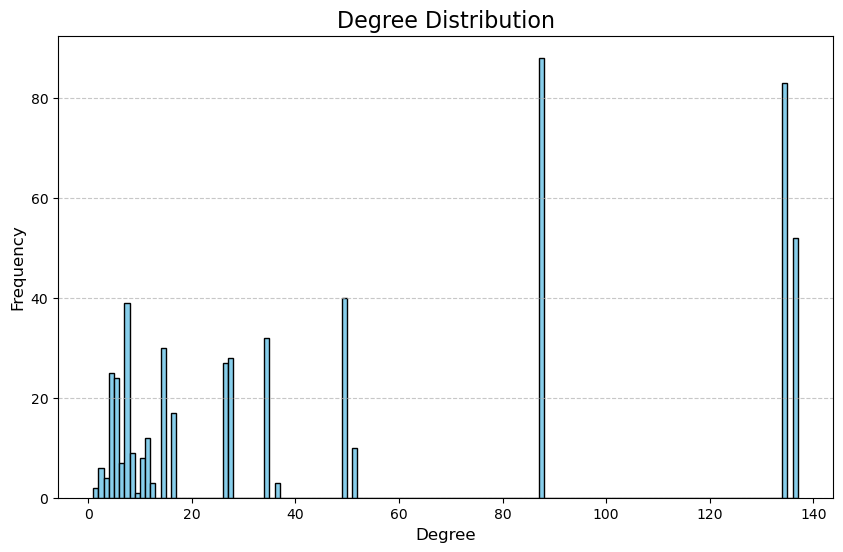

In [53]:

G = create_graph(df)

plot_graph(G)
compute_metrics_and_plot(G)


In [31]:
def create_weighted_graph(df):

    G = nx.Graph()

    # Parse 'Part Of' values into lists
    df["Part Of"] = df["Part Of"].fillna("").apply(lambda x: x.split(";"))

    # Create edges based on shared 'Part Of' values
    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            # Calculate shared 'Part Of' values
            shared_part_of = set(df.iloc[i]["Part Of"]) & set(df.iloc[j]["Part Of"])
            if shared_part_of:
                # Add or update edge weight
                weight = len(shared_part_of)
                if G.has_edge(df.iloc[i]["Program"], df.iloc[j]["Program"]):
                    G[df.iloc[i]["Program"]][df.iloc[j]["Program"]]["weight"] += weight
                else:
                    G.add_edge(df.iloc[i]["Program"], df.iloc[j]["Program"], weight=weight)
    return G

def plot_weighted_graph(G):

    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42)  # Generate layout for consistent plots

    # Extract edge weights for visual representation
    edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

    nx.draw(
        G, pos, with_labels=False, node_color="lightblue", edge_color="gray", node_size=10
    )
    nx.draw_networkx_edges(
        G, pos, edgelist=edges, edge_color=weights, edge_cmap=plt.cm.Blues, width=2
    )

    plt.title("Program Collaboration Graph Based on 'Part Of' Values", fontsize=16)
    plt.show()

def compute_metrics_and_plot_weighted(G):

    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    degree_dist = [d for n, d in G.degree()]
    weight_dist = [attr["weight"] for _, _, attr in G.edges(data=True)]
    clustering_coefficient = nx.average_clustering(G, weight="weight")
    connected_components = list(nx.connected_components(G))
    largest_component_size = len(max(connected_components, key=len))

    metrics = {
        "Number of Nodes": num_nodes,
        "Number of Edges": num_edges,
        "Average Degree": sum(degree_dist) / num_nodes if num_nodes > 0 else 0,
        "Clustering Coefficient": clustering_coefficient,
        "Number of Connected Components": len(connected_components),
        "Largest Component Size": largest_component_size,
        "Average Edge Weight": sum(weight_dist) / len(weight_dist) if weight_dist else 0,
    }

    print("Graph Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value}")

    # Plot degree distribution
    plt.figure(figsize=(10, 6))
    plt.hist(degree_dist, bins=range(min(degree_dist), max(degree_dist) + 2), color="skyblue", edgecolor="black")
    plt.title("Degree Distribution", fontsize=16)
    plt.xlabel("Degree", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    plt.figure(figsize=(10, 6))
    plt.hist(weight_dist, bins=range(1, max(weight_dist) + 2), color="lightgreen", edgecolor="black")
    plt.title("Edge Weight Distribution", fontsize=16)
    plt.xlabel("Edge Weight", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


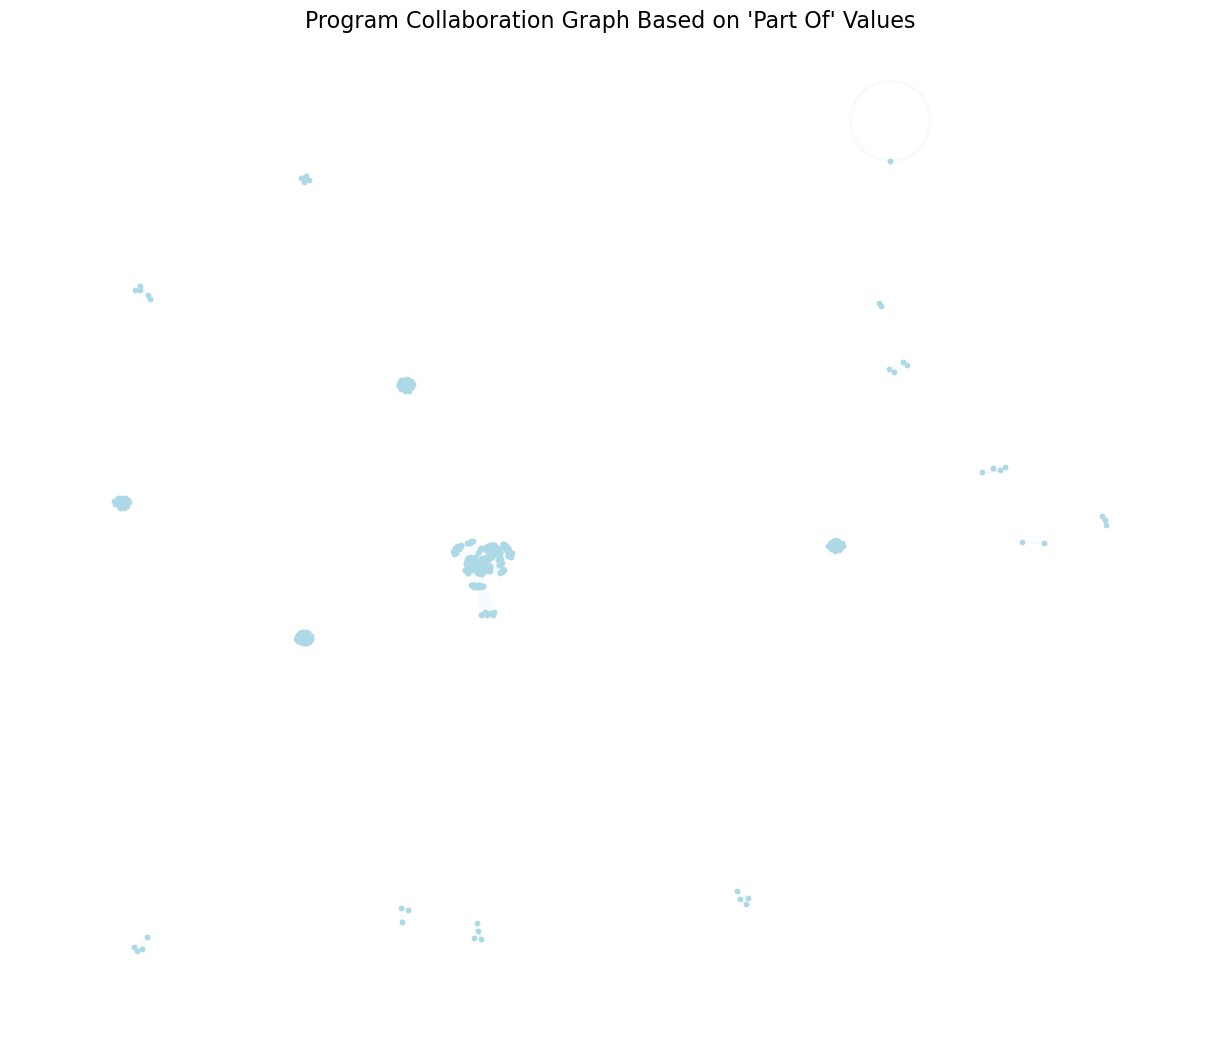

Graph Metrics:
Number of Nodes: 549
Number of Edges: 24753
Average Degree: 90.17486338797814
Clustering Coefficient: 0.11353258564272659
Number of Connected Components: 17
Largest Component Size: 371
Average Edge Weight: 1.6491738375146447


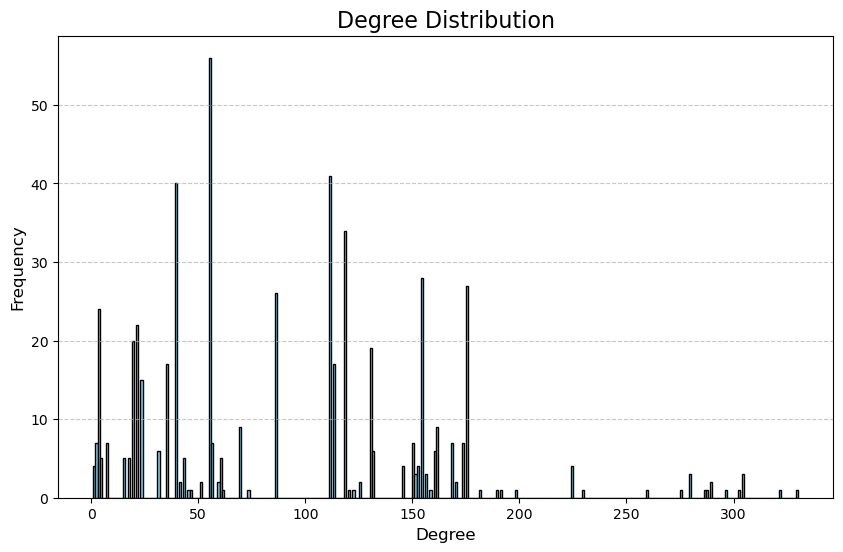

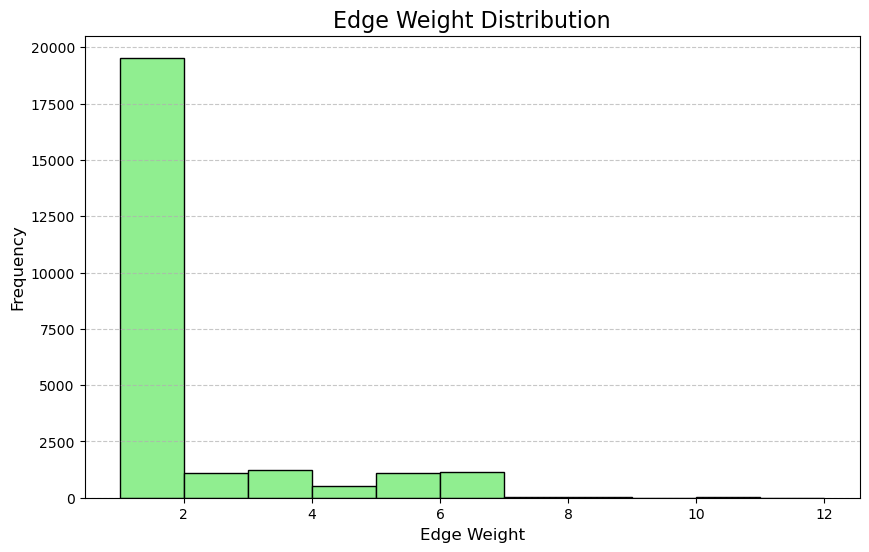

In [32]:

G_weighted = create_weighted_graph(df)

plot_weighted_graph(G_weighted)
compute_metrics_and_plot_weighted(G_weighted)


In [35]:
def analyze_graph(G, top_n=5):

    degrees = dict(G.degree())
    sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
    highest_degree_nodes = sorted_degrees[:top_n]
    lowest_degree_nodes = sorted_degrees[-top_n:]


    edge_weights = nx.get_edge_attributes(G, 'weight')
    sorted_edge_weights = sorted(edge_weights.items(), key=lambda x: x[1], reverse=True)
    highest_weight_edges = sorted_edge_weights[:top_n]
    lowest_weight_edges = sorted_edge_weights[-top_n:]


    analysis = {
        "Top Highest Degree Nodes": highest_degree_nodes,
        "Top Lowest Degree Nodes": lowest_degree_nodes,
        "Top Highest Weight Edges": highest_weight_edges,
        "Top Lowest Weight Edges": lowest_weight_edges,
    }


    print("Graph Analysis:")
    for key, value in analysis.items():
        print(f"\n{key}:")
        for item in value:
            print(f"  {item}")

    return analysis


In [36]:

analysis = analyze_graph(G_weighted)


Graph Analysis:

Top Highest Degree Nodes:
  ('Minor 30 Law', 329)
  ('Minor 30 Biology', 321)
  ('Minor 30 Economics', 304)
  ('Minor 30 Business Administration', 304)
  ('Minor 30 Banking and Finance', 304)

Top Lowest Degree Nodes:
  ('Teaching Subject Veranstaltungen Privatdozierende', 2)
  ('Doctoral Program Informatics', 1)
  ('Doctoral Program Informatics (fast track)', 1)
  ('Single Major 90 Law', 1)
  ('Single Major 90 International and Comparative Law', 1)

Top Highest Weight Edges:
  (('Minor 30 Economics', 'Minor 30 Business Administration'), 11)
  (('Minor 30 Economics', 'Minor 30 Banking and Finance'), 11)
  (('Minor 30 Business Administration', 'Minor 30 Banking and Finance'), 11)
  (('Minor 30 Biology', 'Minor 30 Law'), 11)
  (('Minor 30 Hermeneutics', 'Minor 30 Law'), 11)

Top Lowest Weight Edges:
  (('Major Economics (Fast Track)', 'Major Betriebswirtschaftslehre (Fast Track)'), 1)
  (('Major Economics (Fast Track)', 'Major Banking and Finance (Fast Track)'), 1)
  (('

In [38]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_assortativity_scatter(graph, random_graph, title):
    # the average degree connectivity for the original graph
    knn_graph = nx.average_degree_connectivity(graph)

    # the average degree connectivity for the randomized graph
    knn_random_graph = nx.average_degree_connectivity(random_graph)

    # assortativity coefficient for the real and randomized networks
    assortativity_real = nx.degree_assortativity_coefficient(graph)
    assortativity_random = nx.degree_assortativity_coefficient(random_graph)

    # extract degrees (k) and corresponding average neighbor degrees (k_nn(k))
    degrees_graph = list(knn_graph.keys())
    knn_values_graph = list(knn_graph.values())

    degrees_random_graph = list(knn_random_graph.keys())
    knn_values_random_graph = list(knn_random_graph.values())

    # plot for the original and randomized graphs
    plt.figure(figsize=(8, 6))

    # plot for original network
    plt.scatter(degrees_graph, knn_values_graph, color='blue', edgecolor='black', alpha=0.7, label=f'Original Network (r = {assortativity_real:.3f})')

    # plot for randomized network
    plt.scatter(degrees_random_graph, knn_values_random_graph, color='red', edgecolor='black', alpha=0.5, label=f'Randomized Network (r = {assortativity_random:.3f})')

    # plot title and labels
    plt.title(f'Scatter plot of $k_{{nn}}(k)$ vs Degree $k$\nOriginal vs Randomized Network\n{title}')
    plt.xlabel('Degree $k$')
    plt.ylabel('Average Degree of Nearest Neighbors $k_{{nn}}(k)$')
    plt.grid(True)
    plt.legend()
    plt.show()

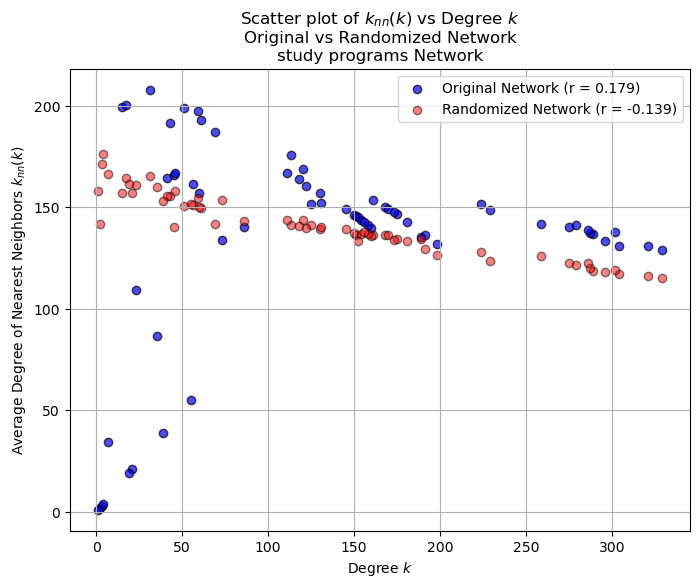

In [39]:

random_graph = nx.algorithms.smallworld.random_reference(G_weighted, niter=2, connectivity=False)
plot_assortativity_scatter(G_weighted, random_graph, f'study programs Network')

In [40]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities, label_propagation_communities
import random

# update function
def draw_randomized_communities(G, communities_original, communities_randomized, title):
    # color map for original graph
    community_map_original = {}
    for i, community in enumerate(communities_original):
        for node in community:
            community_map_original[node] = i

    #  color map for randomized graph
    community_map_randomized = {}
    for i, community in enumerate(communities_randomized):
        for node in community:
            community_map_randomized[node] = i

    # positions for both graphs
    pos_original = nx.spring_layout(G, seed=42)
    pos_randomized = nx.spring_layout(G, seed=42)
    # plot side by side
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))

    # original graph with communities
    plt.sca(ax[0])
    nx.draw_networkx_nodes(G, pos_original, node_size=500, cmap=plt.cm.rainbow,
                           node_color=[community_map_original[node] for node in G.nodes()])
    nx.draw_networkx_edges(G, pos_original, edgelist=G.edges(), edge_color="black", alpha=0.5)
    nx.draw_networkx_labels(G, pos_original)
    plt.title(title + " - Original - " + str(len(communities_original)) + " communities")

    # randomized graph with communities
    plt.sca(ax[1])
    nx.draw_networkx_nodes(G, pos_randomized, node_size=500, cmap=plt.cm.rainbow,
                           node_color=[community_map_randomized[node] for node in G.nodes()])
    nx.draw_networkx_edges(G, pos_randomized, edgelist=G.edges(), edge_color="black", alpha=0.5)
    nx.draw_networkx_labels(G, pos_randomized)
    plt.title(title + " - Randomized - "+ str(len(communities_randomized)) + " communities")

    plt.tight_layout()
    plt.show()

# randomize the network and apply community detection on both the original and randomized network
def randomize_and_compare_communities(graph_name, G):
    # detect communities on the original graph
    gc_original = list(greedy_modularity_communities(G))
    lc_original = list(label_propagation_communities(G))

    # randomize the graph while preserving the degree distribution
    G_randomized = G.copy()
    nx.double_edge_swap(G_randomized, nswap=10 * G.number_of_edges(), max_tries=10000)

    # detect communities on the randomized graph
    gc_randomized = list(greedy_modularity_communities(G_randomized))
    lc_randomized = list(label_propagation_communities(G_randomized))

    # side by side comparison for Greedy Modularity Maximization

    print(f"Greedy Modularity Communities (Original): number = {len(gc_original)}, communities:  {gc_original}")
    print(f"Greedy Modularity Communities (Randomized): number = {len(gc_randomized)}, communities:  {gc_randomized}")
    draw_randomized_communities(G, gc_original, gc_randomized, graph_name + " Greedy Modularity Maximization")

    # side by side comparison for Label Propagation Algorithm
    print(f"Label Propagation Communities (Original): number = {len(lc_original)}, communities:  {lc_original}")
    print(f"Label Propagation Communities (Randomized): number = {len(lc_randomized)}, communities:  {lc_randomized}")
    draw_randomized_communities(G, lc_original, lc_randomized, graph_name + " Label Propagation Algorithm")


In [42]:
# randomize_and_compare_communities(" weight", G_weighted)

In [46]:
def draw_communities(G, communities, title):
    # color map
    community_map = {}
    for i, community in enumerate(communities):
        for node in community:
            community_map[node] = i

    pos = nx.spring_layout(G)


    plt.figure(figsize=(10, 7))
    nx.draw_networkx_nodes(G, pos,  node_size=500, cmap=plt.cm.rainbow,
                           node_color=[community_map[node] for node in G.nodes()])

    # edges: black for internal, gray for external links
    internal_edges = []
    external_edges = []
    for edge in G.edges():
        if community_map[edge[0]] == community_map[edge[1]]:
            internal_edges.append(edge)
        else:
            external_edges.append(edge)

    nx.draw_networkx_edges(G, pos,  edgelist=internal_edges, edge_color="black")
    nx.draw_networkx_edges(G, pos, edgelist=external_edges, edge_color="gray", style="dashed")


    # nx.draw_networkx_labels(G, pos )

    plt.title(title)
    plt.show()

Greedy Modularity Communities: number = 18, communities: [frozenset({'Single Major 90 Medical Biology (specialized Master)', 'Minor 30 Religions in the Ancient World', 'Major 90 Biochemistry', 'Concentration Paleontology', 'Teaching Subject Inter-/Transdisciplinary Courses', 'Single Major 120 Philosophy in Asia and the Islamic World', 'Concentration Virology', 'Single Major 90 Chemistry and Business Studies', 'Single Major 90 Computational Science (specialized Master)', 'Single Major 120 Theology', 'Concentration Microbiology', 'Major 90 Italian Literature/Linguistics', 'Major 90 Biology', 'Major 90 German Literature/Linguistics', 'Single Major 90 Quantitative Environmental Sciences (specialized Master)', 'Major 90 Physics (Fast Track)', 'Minor 30 Social Sciences', 'Major 90 Communication Science and Media Research', 'Major 90 Political Communication &amp; Governance', 'Minor 30 Scandinavian Studies', 'Minor 30 Biblical Studies', 'Minor 30 Slavonic Literatures/Linguistics', 'Minor 30 H

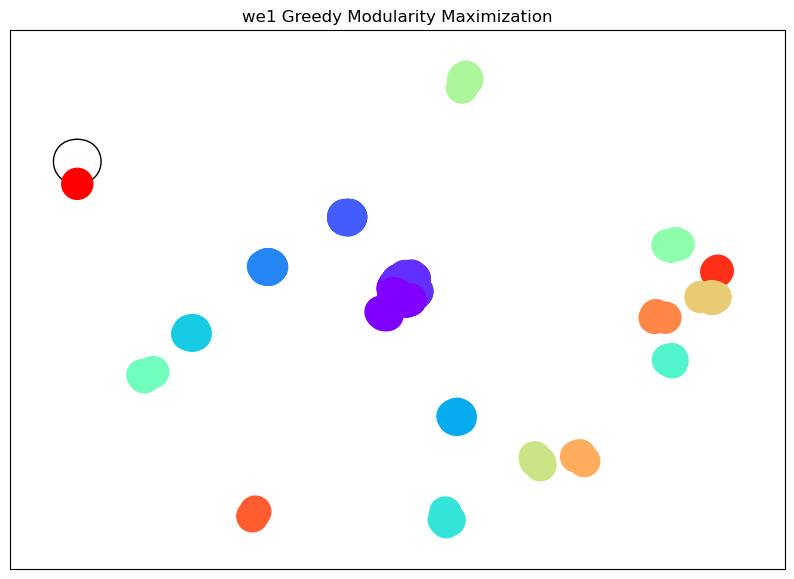

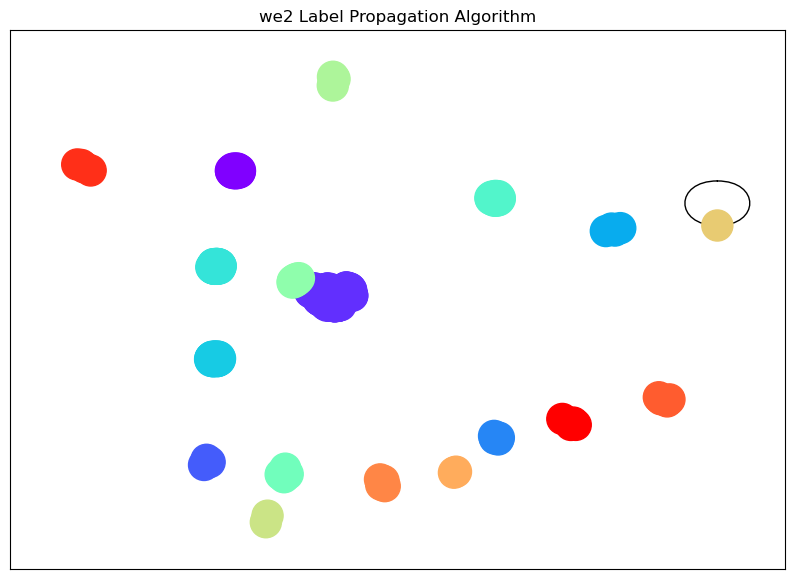

In [47]:
G = G_weighted
gc = list(greedy_modularity_communities(G))
print(f"Greedy Modularity Communities: number = {len(gc)}, communities: {gc}")

lc = list(label_propagation_communities(G))
print(f"Label Propagation Communities: number = {len(lc)}, communities: {lc}")


draw_communities(G, gc, "we1" +" Greedy Modularity Maximization")

draw_communities(G, lc, "we2" +" Label Propagation Algorithm")